In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import torch
from torch import vmap

from src.energies.base_prior import MeanFreePrior

from src.models.components.clipper import Clipper
from src.utils.data_utils import remove_mean

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles
temperature = 2.0

from src.energies.lennardjones_energy import LennardJonesEnergy
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=temperature
    )

In [5]:
target_temp_07 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=0.7
    )

target_temp_08 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=0.8
    )

target_temp_1 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= f"../../data/",
    smooth=False,
    temperature=1.0
    )

## Function Definitions

In [6]:
from src.models.components.utils import sample_cat_sys
from src.models.components.sdes import VEReverseSDE

In [7]:
# class VEReverse_coupled(torch.nn.Module):
#     noise_type = "diagonal"
#     sde_type = "ito"

#     def __init__(self, model, noise_schedule):
#         super().__init__()
#         self.model = model
#         self.noise_schedule = noise_schedule

#     def f(self, t, x, resampling_interval=None, inverse_temperature=1.0):
#         if t.dim() == 0:
#             # repeat the same time for all points if we have a scalar time
#             t = t * torch.ones(x.shape[0]).to(x.device)

#         with torch.enable_grad():
#             x.requires_grad_(True)
#             t.requires_grad_(True)

#             nabla_Ut = self.model(t, x)
#             drift_X = inverse_temperature * nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

#             drift_A = torch.zeros(x.shape[0]).to(x.device)
            
#             if resampling_interval is None:
#                 return  drift_X.detach(), drift_A.detach()
            
#             drift_A = 0.5 * ((self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
#                              * (inverse_temperature-1) * inverse_temperature)
            
#         return  drift_X.detach(), drift_A.detach()

#     def g(self, t, x):
#         g = self.noise_schedule.g(t)
#         return g

def euler_maruyama_step_coupled(sde, x, t, a, dt, step, diffusion_scale,
                                resampling_interval, inverse_temp, u_next):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval, inverse_temp)
    drift_Xt = drift_Xt * dt
    drift_At = drift_At * dt

    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones_like(x).to(device)
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device) * diffusion_scale

    # Update the state
    x_next = x + drift_Xt + diffusion
    a_next = a + drift_At

    if resampling_interval==-1 or step % resampling_interval != 0:
        return x_next, a_next, u_next

    #resample based on the weights
    #choice, _ = sample_cat(x.shape[0], u_next, a_next)
    choice, u_next = sample_cat_sys(x.shape[0], u_next, a_next)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next, u_next


def integrate_sde_coupled(sde, x0, t_span, dt, diffusion_scale, 
                          resampling_interval, inverse_temp):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    a = torch.zeros(x.shape[0]).to(device)
    u_next = 0.5
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a, u_next = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step+1, diffusion_scale,
                                                       resampling_interval, inverse_temp, u_next)
            x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
    return torch.stack(samples), torch.stack(logweights)


def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, diffusion_scale=1.0,
                              resampling_interval=-1, inverse_temp=1.0):
    if samples is None:
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights = integrate_sde_coupled(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        diffusion_scale=diffusion_scale,
        resampling_interval = resampling_interval,
        inverse_temp=inverse_temp
    )
    return samples[-1], weights

In [8]:
from src.models.components.score_estimator import estimate_grad_Rt
def reward_matching_loss(model,
                         energy,
                         x,
                         t,
                         noise_schedule,
                         num_mc_samples=100,
                         clipper=None,
    ):


    x.requires_grad = True
    h_t = noise_schedule.h(t.unsqueeze(1))
    
    # noisy sample: x(t)
    xt = torch.normal(x, h_t**0.5)

    # predicted score
    pred_scores = model(t, xt)

    estimated_scores = estimate_grad_Rt(
        t,
        xt,
        energy,
        noise_schedule,
        num_mc_samples=num_mc_samples,
    ).detach()

    if clipper is not None:
        estimated_scores = clipper.clip_scores(estimated_scores)

    err = (
        estimated_scores - pred_scores
    ) ** 2
    return err.mean()

### Training

In [10]:
from src.models.components.noise_schedules import GeometricNoiseSchedule, QuadraticNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.01, sigma_max=4)

prior samples torch.Size([2048, 39])


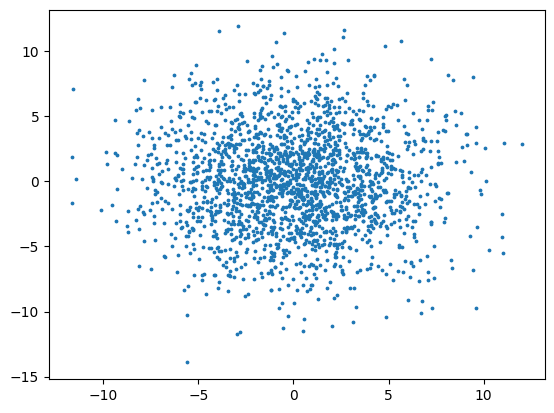

In [11]:
prior = MeanFreePrior(n_particles, spatial_dim, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(2048).detach().cpu()
plt.scatter(x1_samples[:, 0], x1_samples[:, 1], s=3)

print("prior samples", x1_samples.shape)

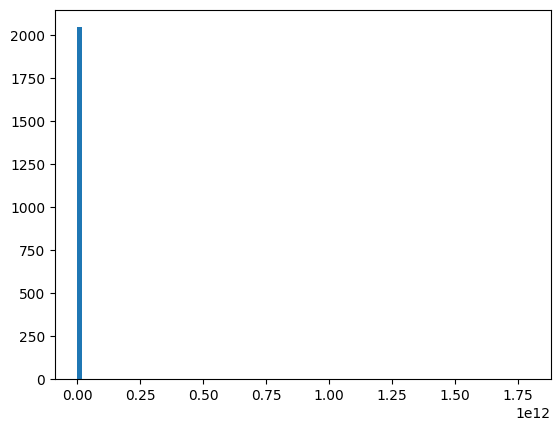

In [12]:
x1_enegry = target(x1_samples)
plt.hist(-x1_enegry.detach().cpu().numpy(), bins=100);

In [31]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    dimensionality,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)

Buffer not initialised, expected that checkpoint will be loaded.


In [32]:
clipper = Clipper(
    should_clip_scores=True, should_clip_log_rewards=False, max_score_norm=500
)
clipper.energy_function = target

In [33]:
outer_epochs= 50
inner_epochs = 100

batch_size = 1024

x1_samples_energy = target(x1_samples.detach())
buffer.add(x1_samples, x1_samples_energy)

train_dataset = TensorDataset(x1_samples.detach(), x1_samples_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

num_mc_samples = 1000

In [34]:
from src.models.components.egnn import EGNN_dynamics
model = EGNN_dynamics(n_particles=target.n_particles,
                      n_dimension=target.n_spatial_dim,
                      hidden_nf=64,
                      act_fn=torch.nn.SiLU(),
                      n_layers=3,
                      recurrent=True,
                      tanh=True,
                      attention=True,
                      condition_time=True,
                      agg='sum').to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [41]:
optimizer = Adam(model.parameters(), lr=1e-3)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 | Loss 95.620911
Epoch 49 | Loss 135.622040
Epoch 98 | Loss 91.607040


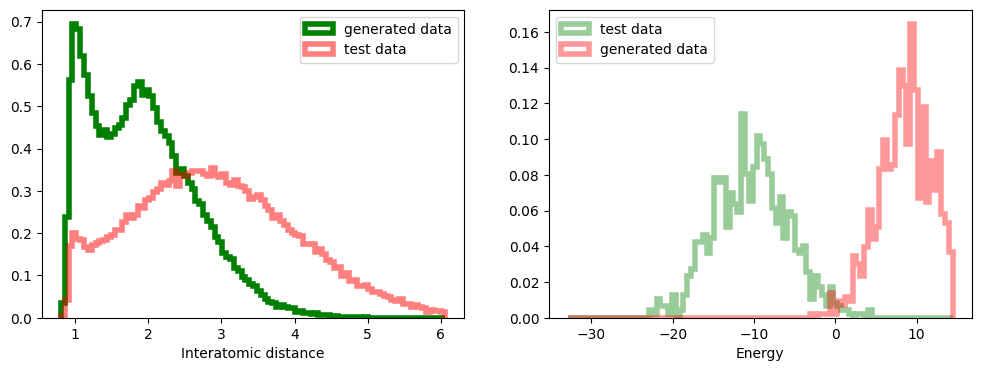

  2%|▏         | 1/50 [00:37<30:29, 37.34s/it]

Mean of Energy tensor(-9.1500, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 16.481520
Epoch 49 | Loss 6.952810
Epoch 98 | Loss 7.834762


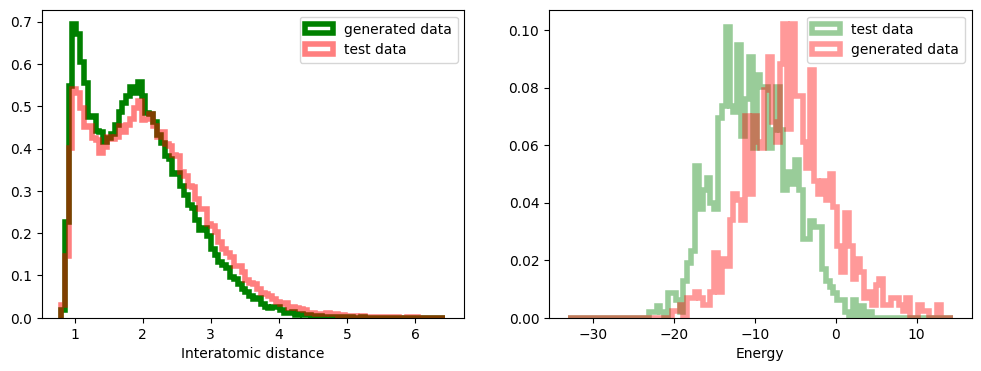

  4%|▍         | 2/50 [02:03<52:48, 66.00s/it]

Mean of Energy tensor(-560.5364, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 6.690596
Epoch 49 | Loss 16.828215
Epoch 98 | Loss 18.346094


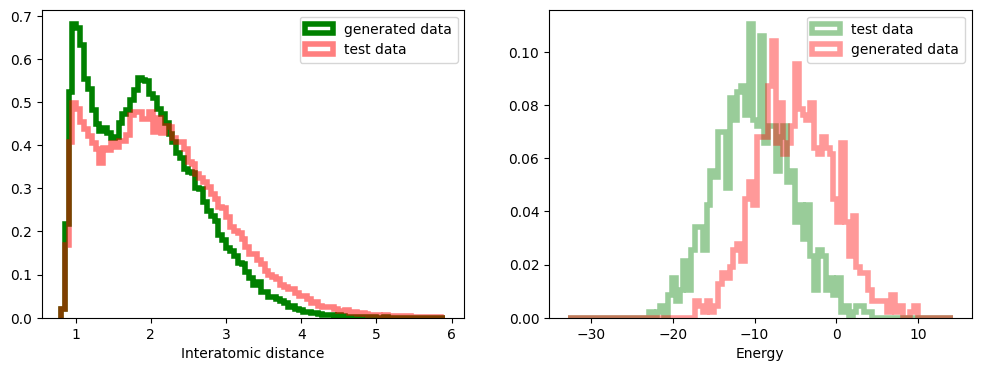

  6%|▌         | 3/50 [03:29<58:48, 75.07s/it]

Mean of Energy tensor(4.9019, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 30.740038
Epoch 49 | Loss 6.944192
Epoch 98 | Loss 21.083841


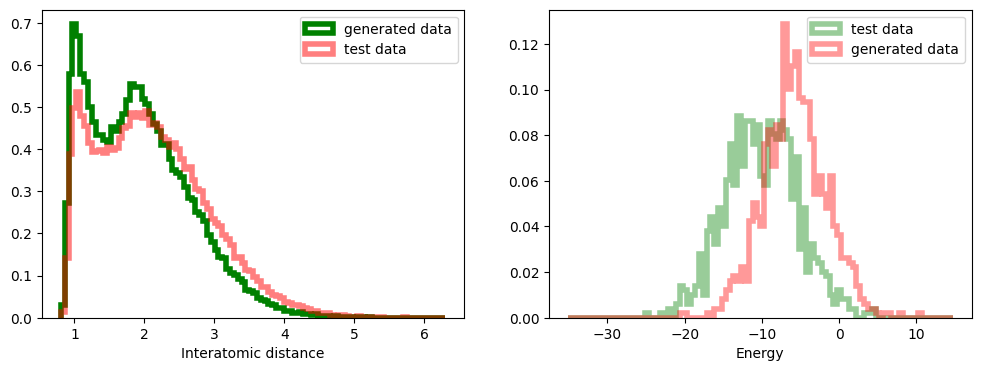

  8%|▊         | 4/50 [04:55<1:00:50, 79.35s/it]

Mean of Energy tensor(5.7199, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 18.166075
Epoch 49 | Loss 13.063540
Epoch 98 | Loss 12.310722


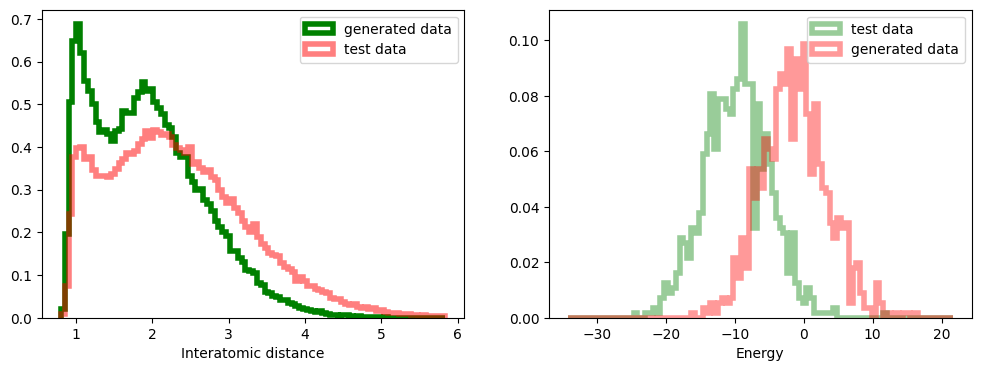

 10%|█         | 5/50 [06:21<1:01:17, 81.71s/it]

Mean of Energy tensor(1.3634, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 20.130865
Epoch 49 | Loss 13.829453
Epoch 98 | Loss 16.279972


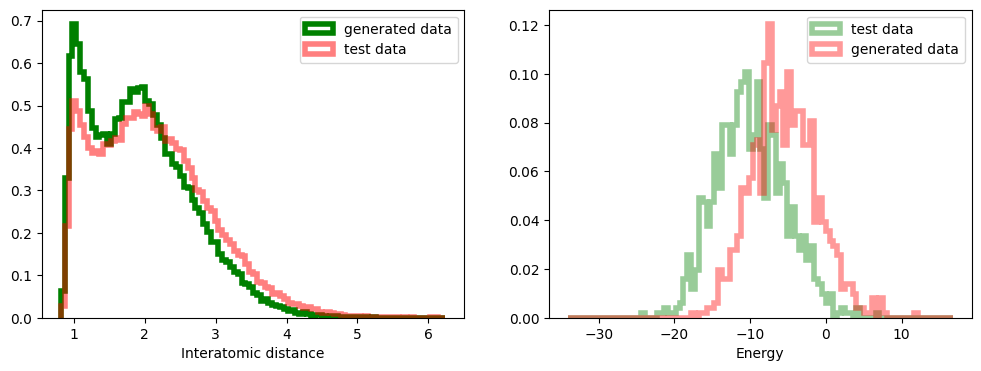

 12%|█▏        | 6/50 [07:46<1:00:57, 83.13s/it]

Mean of Energy tensor(5.4645, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 20.060015
Epoch 49 | Loss 8.569256
Epoch 98 | Loss 10.659020


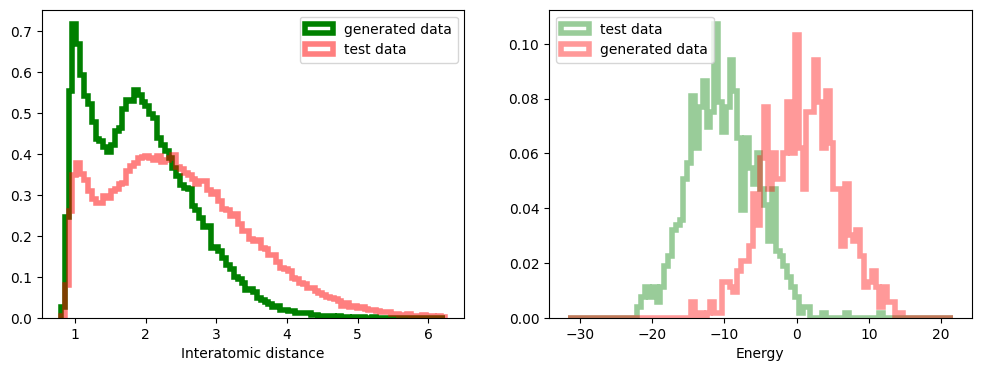

 14%|█▍        | 7/50 [09:12<1:00:13, 84.04s/it]

Mean of Energy tensor(-0.8152, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 10.091436
Epoch 49 | Loss 17.943960
Epoch 98 | Loss 9.817183


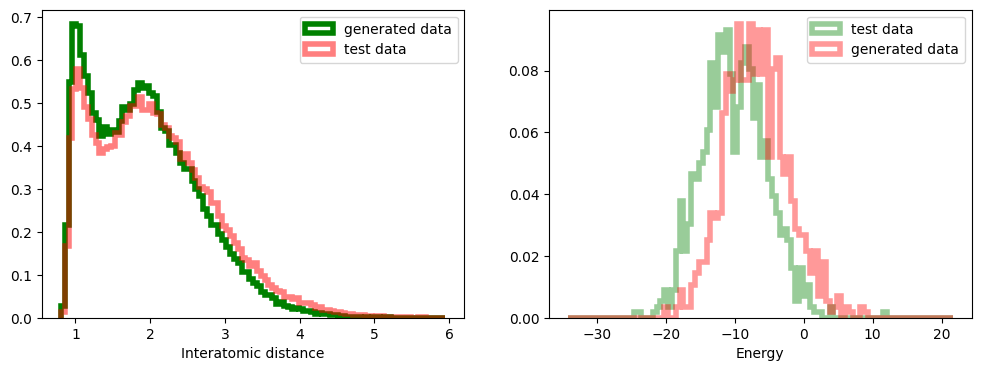

 16%|█▌        | 8/50 [10:38<59:14, 84.63s/it]  

Mean of Energy tensor(6.9025, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 11.322816
Epoch 49 | Loss 10.490970
Epoch 98 | Loss 12.567327


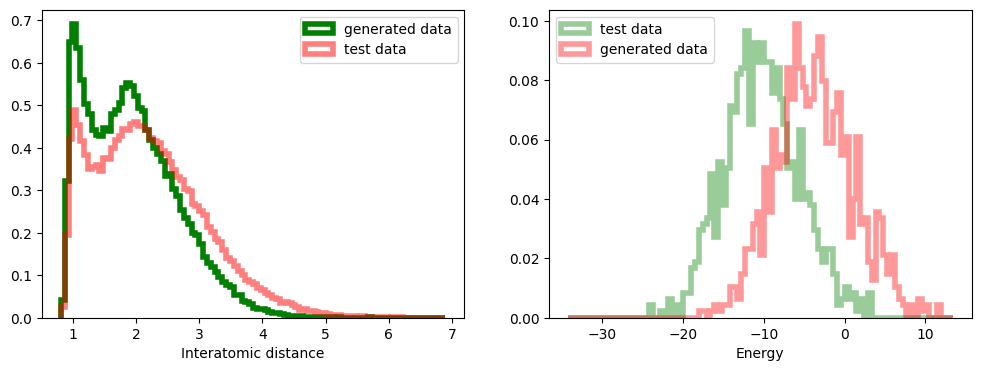

 18%|█▊        | 9/50 [12:04<58:08, 85.07s/it]

Mean of Energy tensor(3.7340, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 9.929805
Epoch 49 | Loss 22.053137
Epoch 98 | Loss 12.387132


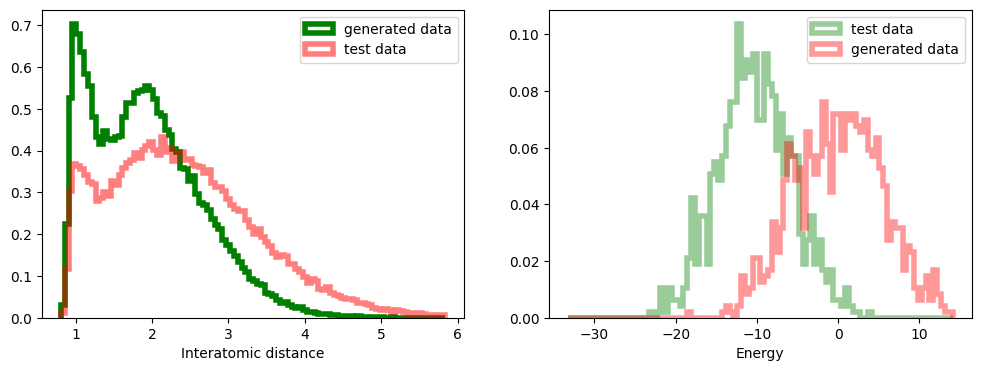

 20%|██        | 10/50 [13:30<56:52, 85.32s/it]

Mean of Energy tensor(-0.0834, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 26.995844
Epoch 49 | Loss 22.401905
Epoch 98 | Loss 9.836184


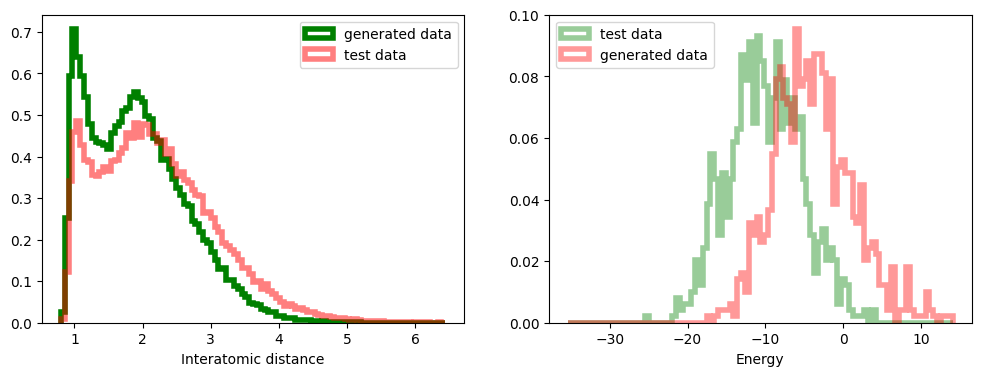

 22%|██▏       | 11/50 [14:56<55:34, 85.51s/it]

Mean of Energy tensor(3.8118, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 18.659414
Epoch 49 | Loss 10.919923
Epoch 98 | Loss 18.004810


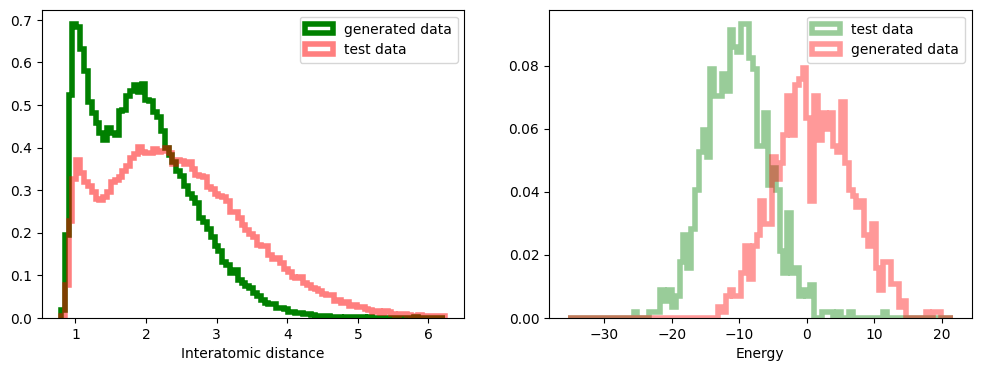

 24%|██▍       | 12/50 [16:22<54:14, 85.64s/it]

Mean of Energy tensor(-1.1198, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch 0 | Loss 13.243997


In [43]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            
            optimizer.zero_grad()

            t = torch.rand(len(samples)).to(device)
            rm_loss= reward_matching_loss(model, 
                                          target,
                                          samples,
                                          t, 
                                          noise_schedule, 
                                          num_mc_samples=num_mc_samples,
                                          clipper=clipper
                                          )
            
            loss = rm_loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverseSDE(model, noise_schedule)
    samples, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=500,
                                           resampling_interval=-1, num_samples=1000)
    samples_energy = target(samples)
    target.get_dataset_fig(samples)
    plt.show()


    # Update Buffer 
    buffer.add(samples,  samples_energy)

    print("Mean of Energy", samples_energy.mean())
    
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(batch_size * 5)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

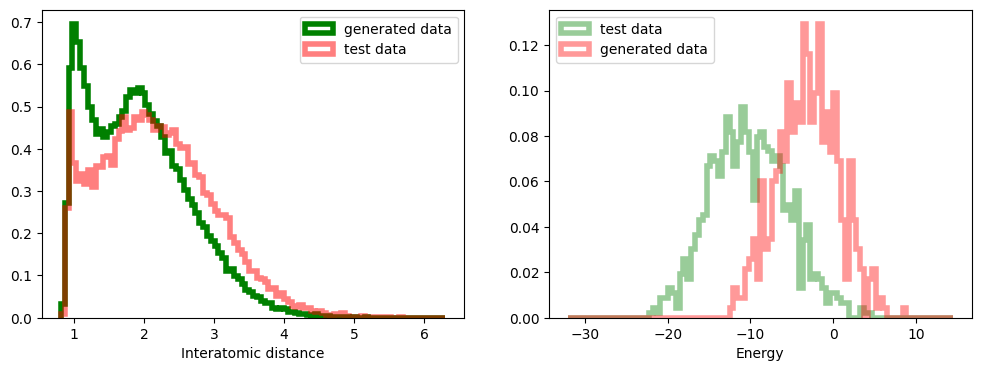

In [37]:
ve_reverse_sde = VEReverseSDE(model, noise_schedule)
samples, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=500,
                                    resampling_interval=-1, num_samples=500)
samples_energy = target(samples)
target.get_dataset_fig(samples)
plt.show()

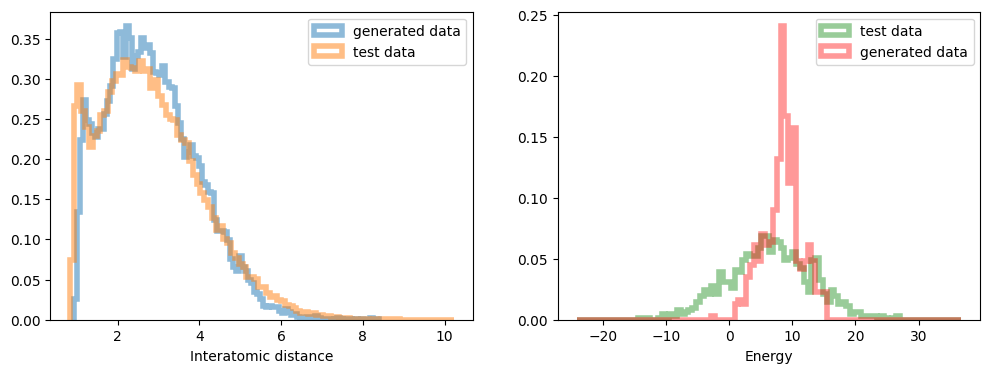

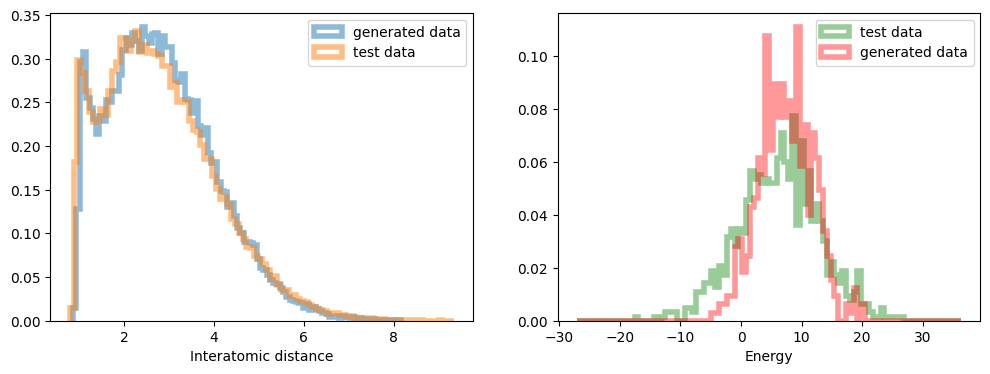

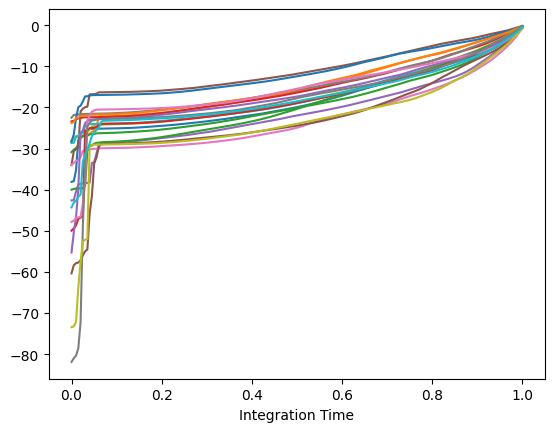

In [ ]:
# for plotting

ve_reverse_sde = VEReverse_coupled(model, noise_schedule)
n_steps = 200
samples_weighted = []
samples = []
log_weights = []
for i in range(1):
    prior_samples = prior.sample(512)
    s_weighted, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                                    num_integration_steps=n_steps, resampling_interval=1, inverse_temp=2.0)
    s, w = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=prior_samples,
                                            num_integration_steps=n_steps, resampling_interval=n_steps+1, inverse_temp=2.0)
    samples_weighted.append(s_weighted)
    samples.append(s)
    log_weights.append(w)

samples_weighted = torch.cat(samples_weighted)
samples = torch.cat(samples)
log_weights = torch.cat(log_weights, dim=1)

target_temp_2.get_dataset_fig(samples_weighted)
# target_temp1.get_dataset_fig(samples_weighted, T=T, T_og=T)
plt.show()

# target.get_dataset_fig(samples, T=T, T_og=T)
target_temp_2.get_dataset_fig(samples)
plt.show()
plt.plot(torch.linspace(1, 0, n_steps)[:], log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")

plt.show()


In [ ]:
target_lowtemp = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/test_split_LJ13-1000.npy",
    data_path_train= "../../data/train_split_LJ13-1000.npy",
    data_path_val= "../../data/test_split_LJ13-1000.npy",
    smooth=False,
    temperature=1.0
    )

samples_energy = target_lowtemp(samples)
samples_weighted_energy = target_lowtemp(samples_weighted)

print("Mean of Energy", samples_energy.mean())
print("Mean of Energy", samples_weighted_energy.mean())
print("True Mean Energy", target_lowtemp(target.test_set).mean())

Mean of Energy tensor(34.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Mean of Energy tensor(30.9028, device='cuda:0', grad_fn=<MeanBackward0>)
True Mean Energy tensor(43.1270, device='cuda:0')
